In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
y = (X[:,0] + X[:,1] == 1).astype(int)

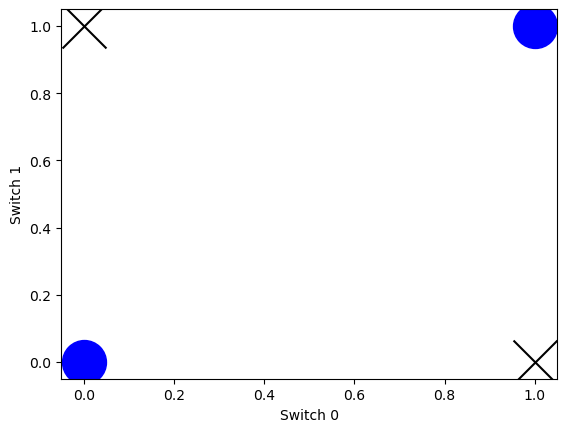

In [3]:
for i in [0, 1]:
    plt.scatter(X[y == i][:,0], X[y == i][:,1], marker=['o', 'x'][i], color=['b', 'k'][i],
    s=1000)
    plt.xlabel('Switch 0')
    plt.ylabel('Switch 1')

In [4]:
np.random.seed(0)
y_simple = np.random.binomial(1, .5, size=10)
X_simple = np.array([[e] for e in y_simple])

In [5]:
count = (X_simple[:,0][y_simple == 0] == 0).sum()
print(f"In {count} instances, both the switch and the light are off")

In 3 instances, both the switch and the light are off


In [6]:
count = (X_simple[:,0][y_simple == 1] == 1).sum()
print(f"In {count} instances, both the switch and the light are on")

In 7 instances, both the switch and the light are on


In [7]:
def get_co_occurrence(X, y, col=0):
    co_occurrence = []
    for i in [0, 1]:
        counts = [(X[:,col][y == i] == j).sum() for j in [0, 1]]
        co_occurrence.append(counts)
    return np.array(co_occurrence)
M = get_co_occurrence(X_simple, y_simple)
assert M[0][0] == 3
assert M[1][1] == 7
print(M)

[[3 0]
 [0 7]]


In [8]:
X_simple

array([[1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0]])

In [9]:
X_simple = np.vstack([X_simple, [1]])

In [10]:
y_simple

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 0])

In [11]:
y_simple = np.hstack([y_simple, [0]])

In [12]:
M = get_co_occurrence(X_simple, y_simple)

In [13]:
M

array([[3, 1],
       [0, 7]])

In [14]:
bulb_probs = M[0] / M[0].sum()
print("When the switch is set to 0, the bulb state probabilities are:")
print(bulb_probs)

When the switch is set to 0, the bulb state probabilities are:
[0.75 0.25]


In [15]:
bulb_probs = M[1] / M[1].sum()
print("When the switch is set to 1, the bulb state probabilities are:")
print(bulb_probs)
prediction = ['off', 'on'][bulb_probs.argmax()]
accuracy = bulb_probs.max()
print(f"\nWe assume the bulb is {prediction} with "
f"{100 * accuracy:.0f}% accuracy")

When the switch is set to 1, the bulb state probabilities are:
[0. 1.]

We assume the bulb is on with 100% accuracy


In [16]:
M.sum(axis=1)

array([4, 7])

In [17]:
accuracies = [.75, 1.]
total_accuracy = np.average(accuracies, weights=M.sum(axis=1))

In [18]:
total_accuracy

0.9090909090909091

In [19]:
def train_if_else(X, y, feature_col=0, feature_name='feature'):
    M = get_co_occurrence(X, y, col=feature_col)
    probs0, probs1 = [M[i]/M[i].sum() for i in [0, 1]]
    if_else = f"""
    if {feature_name} == 0:
        prediction = {probs0.argmax()}
    else:
        prediction = {probs1.argmax()}
    """.strip()
    if probs0.argmax() == probs1.argmax():
        if_else = f"prediction = {probs0.argmax()}"
    accuracies = [probs0.max(), probs1.max()]
    total_accuracy = np.average(accuracies, weights=M.sum(axis=1))
    return if_else, total_accuracy

In [20]:
if_else, accuracy = train_if_else(X_simple, y_simple, feature_name='switch')
print(if_else)
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if switch == 0:
        prediction = 0
    else:
        prediction = 1

This statement is 91% accurate.


In [21]:
feature_names = [f"switch{i}" for i in range(2)]

In [22]:
for i, name in enumerate(feature_names):
    _, accuracy = train_if_else(X, y, feature_col=i, feature_name=name)
    print(f"The model trained on {name} is {100 * accuracy:.0f}% " "accurate.")

The model trained on switch0 is 50% accurate.
The model trained on switch1 is 50% accurate.


In [23]:
is_off = X[:, 0] == 0

In [24]:
is_off

array([ True, False,  True, False])

In [25]:
X_switch0_off = X[is_off]
y_switch0_off = y[is_off]

In [26]:
X_switch0_off

array([[0, 0],
       [0, 1]])

In [27]:
y_switch0_off

array([0, 1])

In [28]:
X_switch0_off = np.delete(X_switch0_off, 0, axis=1)

In [29]:

X_switch0_off

array([[0],
       [1]])

In [30]:
results = train_if_else(X_switch0_off, y_switch0_off, feature_name='switch1')

In [31]:
results

('if switch1 == 0:\n        prediction = 0\n    else:\n        prediction = 1',
 1.0)

In [32]:
switch0_off_model, off_accuracy = results

In [33]:
off_accuracy

1.0

In [34]:
def filter_X_y(X, y, filter_col=0, condition=0):
    inclusion_criteria = X[:, filter_col] == condition
    y_filtered = y[inclusion_criteria]
    X_filtered = np.delete(X[inclusion_criteria], filter_col, axis=1)
    return X_filtered, y_filtered

In [35]:
X_switch0_on, y_switch0_on = filter_X_y(X, y, filter_col=0, condition=1)

In [36]:
results = train_if_else(X_switch0_on, y_switch0_on, feature_name='switch1')

In [37]:
switch0_on_model, on_accuracy = results

In [38]:
on_accuracy

1.0

In [39]:
switch0_on_model

'if switch1 == 0:\n        prediction = 1\n    else:\n        prediction = 0'

In [40]:
def combine_if_else(if_else_a, if_else_b, feature_name='feature'):
    return f"""
    if {feature_name} == 0:
        {add_indent(if_else_a)}
    else:
        {add_indent(if_else_b)}
    """.strip()
def add_indent(if_else):
    return '\n'.join([4 * ' ' + line for line in if_else.split('\n')])

In [41]:
nested_model = combine_if_else(switch0_off_model, switch0_on_model, feature_name='switch0')

In [42]:
nested_model

'if switch0 == 0:\n            if switch1 == 0:\n            prediction = 0\n        else:\n            prediction = 1\n    else:\n            if switch1 == 0:\n            prediction = 1\n        else:\n            prediction = 0'

In [43]:
accuracies = [off_accuracy, on_accuracy]
weights = [y_switch0_off.size, y_switch0_on.size]
total_accuracy = np.average(accuracies, weights=weights)
print(f"Our total accuracy is {100 * total_accuracy:.0f}%")

Our total accuracy is 100%


In [44]:
X, y

(array([[0, 0],
        [1, 0],
        [0, 1],
        [1, 1]]),
 array([0, 1, 1, 0]))

In [45]:
def split(X, y, feature_col=0, condition=0):
    has_condition = X[:, feature_col] == condition
    X_a, y_a = [e[has_condition] for e in [X, y]]
    X_b, y_b = [e[~has_condition] for e in [X, y]]
    X_a, X_b = [np.delete(e, feature_col, axis=1) for e in [X_a, X_b]]
    return [X_a, X_b, y_a, y_b]

In [46]:
X_a, X_b, y_a, y_b = split(X, y)

In [47]:
assert np.array_equal(X_a, X_switch0_off)
assert np.array_equal(X_b, X_switch0_on)

In [48]:
def train_nested_if_else(X, y, split_col=0,
    feature_names=['feature1', 'feature1']):
    split_name = feature_names[split_col]
    simple_model, simple_accuracy = train_if_else(X, y, split_col, split_name)
    if simple_accuracy == 1.0:
        return (simple_model, simple_accuracy)
    X_a, X_b, y_a, y_b = split(X, y, feature_col=split_col)
    in_name = feature_names[1 - split_col]
    if_else_a, accuracy_a = train_if_else(X_a, y_a, feature_name=in_name)
    if_else_b, accuracy_b = train_if_else(X_b, y_b, feature_name=in_name)
    nested_model = combine_if_else(if_else_a, if_else_b, split_name)
    accuracies = [accuracy_a, accuracy_b]
    nested_accuracy = np.average(accuracies, weights=[y_a.size, y_b.size])
    if nested_accuracy > simple_accuracy:
        return (nested_model, nested_accuracy)
    return (simple_model, simple_accuracy)

In [49]:
feature_names = ['switch0', 'switch1']
model, accuracy = train_nested_if_else(X, y, feature_names=feature_names)
print(model)
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if switch0 == 0:
            if switch1 == 0:
            prediction = 0
        else:
            prediction = 1
    else:
            if switch1 == 0:
            prediction = 1
        else:
            prediction = 0

This statement is 100% accurate.


In [50]:
np.random.seed(1)
y_rain = np.random.binomial(1, .6, size=100)
is_wet = [e if np.random.binomial(1, 0.95) else 1 - e for e in y_rain]
is_fall = [e if np.random.binomial(1, 0.6) else 1 - e for e in y_rain]

In [51]:
X_rain = np.array([is_fall, is_wet]).T

In [52]:
X_rain

array([[0, 1],
       [0, 0],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 0],
       [0, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 0],
       [0, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 1],
       [1,

In [53]:
feature_names = ['is_autumn', 'is_wet']
model, accuracy = train_nested_if_else(X_rain, y_rain,
feature_names=feature_names)
print(model)
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if is_autumn == 0:
            if is_wet == 0:
            prediction = 0
        else:
            prediction = 1
    else:
            if is_wet == 0:
            prediction = 0
        else:
            prediction = 1

This statement is 95% accurate.


In [54]:
model, accuracy = train_nested_if_else(X_rain, y_rain, split_col=1,
feature_names=feature_names)

In [55]:
print(model)
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if is_wet == 0:
        prediction = 0
    else:
        prediction = 1

This statement is 95% accurate.


In [56]:
prob_rain = y_rain.sum()/y_rain.size

In [57]:
print(f"It rains in {100 * prob_rain:.0f}% of our observations.")

It rains in 61% of our observations.


In [58]:
y_fall_a, y_fall_b = split(X_rain, y_rain, feature_col=0)[-2:]
for i, y_fall in enumerate([y_fall_a, y_fall_b]):
    prob_rain = y_fall.sum() / y_fall.size
    state = ['not autumn', 'autumn'][i]
    print(f"It rains {100 * prob_rain:.0f}% of the time when it is "
    f"{state}")

It rains 55% of the time when it is not autumn
It rains 66% of the time when it is autumn


In [59]:
y_wet_a, y_wet_b = split(X_rain, y_rain, feature_col=1)[-2:]
for i, y_wet in enumerate([y_wet_a, y_wet_b]):
    prob_rain = y_wet.sum() / y_wet.size
    state = ['not wet', 'wet'][i]
    print(f"It rains {100 * prob_rain:.0f}% of the time when it is "
    f"{state}")

It rains 10% of the time when it is not wet
It rains 98% of the time when it is wet


In [60]:
X_rain

array([[0, 1],
       [0, 0],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [1, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 0],
       [0, 1],
       [0, 1],
       [0, 0],
       [1, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 0],
       [0, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 1],
       [1,

In [61]:
def get_class_distribution(y):
    prob_rain = y.sum()/y.size
    return np.array([1 - prob_rain, prob_rain])

In [62]:
def plot_vector(v, label, linestyle='-', color='b'):
    plt.plot([0, v[0]], [0, v[1]], label=label, linestyle=linestyle, c=color)

In [63]:
classes = [y_fall_a, y_fall_b, y_wet_a, y_wet_b]

(-0.045238095238095244, 0.95, -0.04913793103448276, 1.0318965517241379)

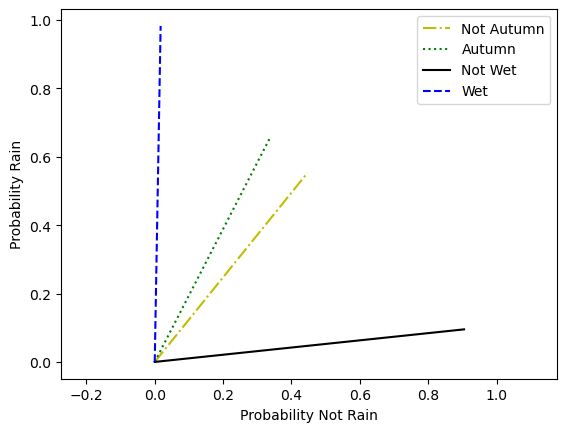

In [64]:
distributions = [get_class_distribution(y) for y in classes]
labels = ['Not Autumn', 'Autumn', 'Not Wet', 'Wet']
colors = ['y', 'g', 'k', 'b']
linestyles = ['-.', ':', '-', '--']
for tup in zip(distributions, labels, colors, linestyles):
    vector, label, color, linestyle = tup
    plot_vector(vector, label, linestyle=linestyle, color=color)
plt.legend()
plt.xlabel('Probability Not Rain')
plt.ylabel('Probability Rain')
plt.axis('equal')

In [65]:
prob_rain = np.arange(0, 1.001, 0.01)

In [66]:
vectors = [np.array([1 - p, p]) for p in prob_rain]
magnitudes = [np.linalg.norm(v) for v in vectors]

In [67]:
magnitudes

[1.0,
 0.9900505037623081,
 0.9802040603874276,
 0.9704638066409277,
 0.9608329719571451,
 0.9513148795220223,
 0.9419129471453294,
 0.9326306878931231,
 0.9234717104492156,
 0.9144397191723466,
 0.9055385138137417,
 0.8967719888578144,
 0.8881441324469806,
 0.8796590248499699,
 0.8713208364316786,
 0.8631338250816034,
 0.8551023330572779,
 0.8472307831990054,
 0.8395236744726143,
 0.8319855767980597,
 0.8246211251235323,
 0.8174350127074324,
 0.8104319835741924,
 0.8036168241145777,
 0.796994353806851,
 0.7905694150420949,
 0.7843468620451031,
 0.7783315488916018,
 0.7725283166331186,
 0.7669419795525604,
 0.7615773105863908,
 0.7564390259630976,
 0.7515317691222374,
 0.7468600939935136,
 0.7424284477308234,
 0.7382411530116699,
 0.7343023900274328,
 0.7306161783043132,
 0.7271863585079137,
 0.724016574395918,
 0.7211102550927979,
 0.7184705978674423,
 0.7161005515987263,
 0.7140028011149536,
 0.7121797525905943,
 0.7106335201775947,
 0.7093659140387281,
 0.7083784299369935,
 0.707672

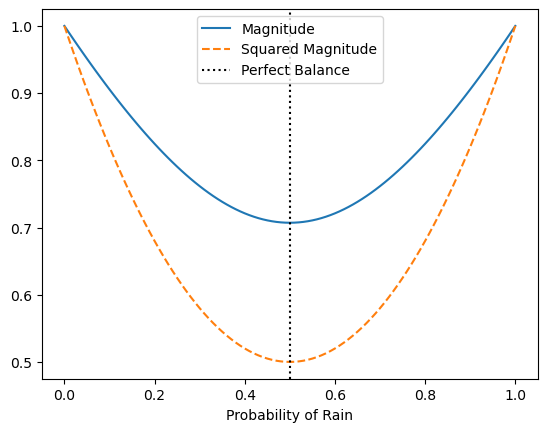

In [68]:
square_magnitudes = [v @ v for v in vectors]
plt.plot(prob_rain, magnitudes, label='Magnitude')
plt.plot(prob_rain, square_magnitudes, label='Squared Magnitude',
linestyle='--')
plt.xlabel('Probability of Rain')
plt.axvline(0.5, color='k', label='Perfect Balance', linestyle=':')
plt.legend()

Text(0, 0.5, 'Gini Impurity')

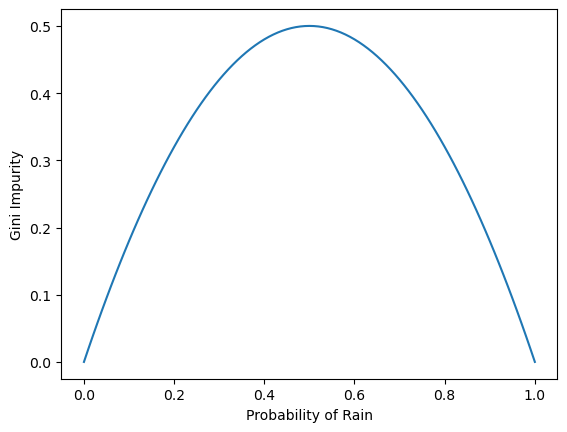

In [69]:
gini_impurities = [1 - (v @ v) for v in vectors]
plt.plot(prob_rain, gini_impurities)
plt.xlabel('Probability of Rain')
plt.ylabel('Gini Impurity')

In [70]:
def compute_impurity(y_a, y_b):
    v_a = get_class_distribution(y_a)
    v_b = get_class_distribution(y_b)
    impurities = [1 - v @ v for v in [v_a, v_b]]
    weights = [y.size, y_b.size]
    return np.average(impurities, weights=weights)
fall_impurity = compute_impurity(y_fall_a, y_fall_b)
wet_impurity = compute_impurity(y_wet_a, y_wet_b)
print(f"When we split on Autumn, the Impurity is {fall_impurity:0.2f}.")
print(f"When we split on Wetness, the Impurity is {wet_impurity:0.2f}.")

When we split on Autumn, the Impurity is 0.45.
When we split on Wetness, the Impurity is 0.04.


In [71]:
def sort_feature_indices(X, y):
    feature_indices = range(X.shape[1])
    impurities = []
    for i in feature_indices:
        y_a, y_b = split(X, y, feature_col=i)[-2:]
        impurities.append(compute_impurity(y_a, y_b))
    return sorted(feature_indices, key=lambda i: impurities[i])
indices = sort_feature_indices(X_rain, y_rain)
top_feature = feature_names[indices[0]]
print(f"The feature with the minimal impurity is: '{top_feature}'")

The feature with the minimal impurity is: 'is_wet'


In [72]:
def simulate_weather():
    is_fall = np.random.binomial(1, .25)
    is_cloudy = np.random.binomial(1, [.3, .7][is_fall])
    rained_today = np.random.binomial(1, [.05, .4][is_cloudy])
    if rained_today:
        rains_tomorrow = np.random.binomial(1, .5)
    else:
        rains_tomorrow = np.random.binomial(1, [.05, .15][is_fall])
    features = [rained_today, is_fall, is_cloudy]
    return features, rains_tomorrow

In [73]:
np.random.seed(0)
X_train, y_train = [], []
for _ in range(1000):
    features, rains_tomorrow = simulate_weather()
    X_train.append(features)
    y_train.append(rains_tomorrow)

In [74]:
X_rain = np.array(X_train)
y_rain = np.array(y_train)

In [75]:
X_rain

array([[1, 0, 1],
       [0, 0, 0],
       [1, 1, 1],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 1]])

In [76]:
y_rain

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,

In [77]:
feature_names = ['rained_today', 'is_fall', 'is_cloudy']

In [78]:
indices = sort_feature_indices(X_rain, y_rain)

In [79]:
indices

[1, 2, 0]

In [80]:
print(f"Features sorted by Gini Impurity:")
print([feature_names[i] for i in indices])

Features sorted by Gini Impurity:
['is_fall', 'is_cloudy', 'rained_today']


In [81]:
skip_index = indices[-1]

In [82]:
X_subset = np.delete(X_rain, skip_index, axis=1)

In [83]:
name_subset = np.delete(feature_names, skip_index)

In [84]:
name_subset

array(['is_fall', 'is_cloudy'], dtype='<U12')

In [85]:
indices[0]

1

In [86]:
skip_index

0

In [87]:
split_col = indices[0] if indices[0] < skip_index else indices[0] - 1

In [88]:
model, accuracy = train_nested_if_else(X_subset, y_rain, split_col=split_col, feature_names=name_subset)

In [89]:
model

'prediction = 0'

In [90]:
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")


This statement is 74% accurate.


In [91]:
X_a, X_b, y_a, y_b = split(X_rain, y_rain, feature_col=indices[0])

In [92]:
name_subset = np.delete(feature_names, indices[0])

In [93]:
X_a

array([[1, 1],
       [0, 0],
       [0, 1],
       ...,
       [0, 0],
       [0, 0],
       [1, 1]])

In [94]:
split_col = sort_feature_indices(X_a, y_a)[0]
model_a, accuracy_a = train_nested_if_else(X_a, y_a, split_col=split_col, feature_names=name_subset)

In [95]:
print("If it is not autumn, then the following nested model is " f"{100 * accuracy_a:.0f}% accurate.\n\n{model_a}")

If it is not autumn, then the following nested model is 88% accurate.

if is_cloudy == 0:
            prediction = 0
    else:
            if rained_today == 0:
            prediction = 0
        else:
            prediction = 1


In [96]:
split_col = sort_feature_indices(X_b, y_b)[0]
model_b, accuracy_b = train_nested_if_else(X_b, y_b, split_col=split_col, feature_names=name_subset)
print("If it is autumn, then the following nested model is "
f"{100 * accuracy_b:.0f}% accurate.\n\n{model_b}")

If it is autumn, then the following nested model is 79% accurate.

if is_cloudy == 0:
            prediction = 0
    else:
            if rained_today == 0:
            prediction = 0
        else:
            prediction = 1


In [97]:
nested_model = combine_if_else(model_a, model_b, feature_names[indices[0]])
print(nested_model)
accuracies = [accuracy_a, accuracy_b]
accuracy = np.average(accuracies, weights=[y_a.size, y_b.size])
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if is_fall == 0:
            if is_cloudy == 0:
                prediction = 0
        else:
                if rained_today == 0:
                prediction = 0
            else:
                prediction = 1
    else:
            if is_cloudy == 0:
                prediction = 0
        else:
                if rained_today == 0:
                prediction = 0
            else:
                prediction = 1

This statement is 85% accurate.


In [98]:
def train(X, y, feature_names):
    if X.shape[1] == 1:
        return train_if_else(X, y, feature_name=feature_names[0])
    indices = sort_feature_indices(X, y)
    X_subset = np.delete(X, indices[-1], axis=1)
    name_subset = np.delete(feature_names, indices[-1])
    simple_model, simple_accuracy = train(X_subset, y, name_subset)
    if simple_accuracy == 1.0:
        return (simple_model, simple_accuracy)
    split_col = indices[0]
    name_subset = np.delete(feature_names, split_col)
    X_a, X_b, y_a, y_b = split(X, y, feature_col=split_col)
    model_a, accuracy_a = train(X_a, y_a, name_subset)
    model_b, accuracy_b = train(X_b, y_b, name_subset)
    accuracies = [accuracy_a, accuracy_b]
    total_accuracy = np.average(accuracies, weights=[y_a.size, y_b.size])
    nested_model = combine_if_else(model_a, model_b, feature_names[split_col])
    if total_accuracy > simple_accuracy:
        return (nested_model, total_accuracy)
    return (simple_model, simple_accuracy)

In [99]:
model, accuracy = train(X_rain, y_rain, feature_names)
print(model)
print(f"\nThis statement is {100 * accuracy:.0f}% accurate.")

if rained_today == 0:
        prediction = 0
    else:
        prediction = 1

This statement is 83% accurate.
